## Gradient Descent


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import pickle
import time
import numpy as np
import keras.optimizers
from sklearn.metrics import classification_report
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
IMG_SIZE = 224

In [3]:
def load_data(data_dir, img_size):
    images = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_size, img_size))
            image = image.astype("float32") / 255.0
            images.append(image)
            labels.append(class_name)
    label_binarizer = LabelBinarizer()
    labels = label_binarizer.fit_transform(labels)
    return np.array(images), labels, label_binarizer.classes_

In [4]:
train_data_dir = "./Brain Tumor/Training"
test_data_dir = "./Brain Tumor/Testing"

In [5]:
train_images, train_labels, classes = load_data(train_data_dir, IMG_SIZE)
print("Loaded", len(train_images), "Training images.")
print("Belonging to", len(classes), "classes:", classes)

Loaded 2870 Training images.
Belonging to 4 classes: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [6]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print("Number of training images:", len(train_images))
print("Number of validation images:", len(val_images))

Number of training images: 2296
Number of validation images: 574


In [7]:
test_images, test_labels, classes = load_data(test_data_dir, IMG_SIZE)
print("Loaded", len(test_images), "Testing images.")
print("Belonging to", len(classes), "classes:", classes)

Loaded 394 Testing images.
Belonging to 4 classes: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [8]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential(
        [
            Conv2D(
                32, (3, 3), activation="relu", padding="same", input_shape=input_shape
            ),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation="relu"),
            Dropout(0.5),
            Dense(num_classes, activation="softmax"),
        ]
    )

    return model

In [9]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 4

In [10]:
x = create_cnn_model(input_shape, num_classes)
x.summary()

c:\Anaconda\envs\tensorflowgpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,452 (49.93 MB)

 Trainable params: 13,088,452 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
len(x.layers)

12

In [12]:
x.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
history = x.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping],
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 751ms/step - accuracy: 0.4811 - loss: 1.2453 - val_accuracy: 0.6150 - val_loss: 0.8662
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 730ms/step - accuracy: 0.6688 - loss: 0.7595 - val_accuracy: 0.7596 - val_loss: 0.6012
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 723ms/step - accuracy: 0.8004 - loss: 0.5077 - val_accuracy: 0.8084 - val_loss: 0.4795
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 724ms/step - accuracy: 0.8577 - loss: 0.3585 - val_accuracy: 0.8537 - val_loss: 0.4103
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 731ms/step - accuracy: 0.9115 - loss: 0.2510 - val_accuracy: 0.8868 - val_loss: 0.3322
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 739ms/step - accuracy: 0.9380 - loss: 0.1674 - val_accuracy: 0.8902 - val_loss: 0.3483
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 729ms/step - accuracy: 0.9655 - loss: 0.0985 - val_accuracy: 0.9024 - val_loss: 0.3479
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 732ms/step - accuracy: 0.9707 - loss: 0.0862 - 

In [14]:
test_loss, test_accuracy = x.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4733 - loss: 5.3122
Test Loss: 2.815896511077881
Test Accuracy: 0.6548223495483398


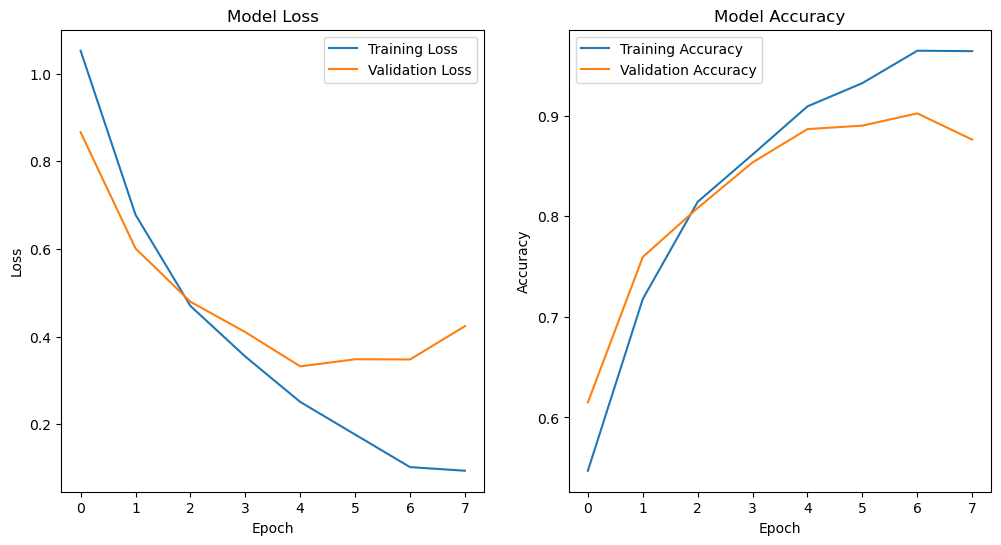

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [21]:
def create_cnn_model0(input_shape, num_classes):
    model = Sequential(
        [
            Conv2D(
                32, (3, 3), activation="relu", padding="valid", input_shape=input_shape
            ),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu", padding="valid"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu", padding="valid"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu", padding="valid"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation="relu"),
            Dropout(0.5),
            Dense(num_classes, activation="softmax"),
        ]
    )

    return model

In [22]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 4

In [23]:
model = create_cnn_model0(input_shape, num_classes)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,680,580 (36.93 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history0 = model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping],
)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 688ms/step - accuracy: 0.4648 - loss: 1.2167 - val_accuracy: 0.6359 - val_loss: 0.7870
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 686ms/step - accuracy: 0.7091 - loss: 0.6829 - val_accuracy: 0.7718 - val_loss: 0.5721
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 688ms/step - accuracy: 0.7968 - loss: 0.4972 - val_accuracy: 0.7770 - val_loss: 0.5595
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 688ms/step - accuracy: 0.8448 - loss: 0.3984 - val_accuracy: 0.8467 - val_loss: 0.4155
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 688ms/step - accuracy: 0.9000 - loss: 0.2445 - val_accuracy: 0.8711 - val_loss: 0.3368
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 704ms/step - accuracy: 0.9372 - loss: 0.1964 - val_accuracy: 0.8815 - val_loss: 0.3718
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 683ms/step - accuracy: 0.9493 - loss: 0.1404 - val_accuracy: 0.9024 - val_loss: 0.2919
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 683ms/step - accuracy: 0.9620 - loss: 0.1055 - 

In [26]:
test_loss, test_accuracy = x.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.4733 - loss: 5.3122
Test Loss: 2.815896511077881
Test Accuracy: 0.6548223495483398


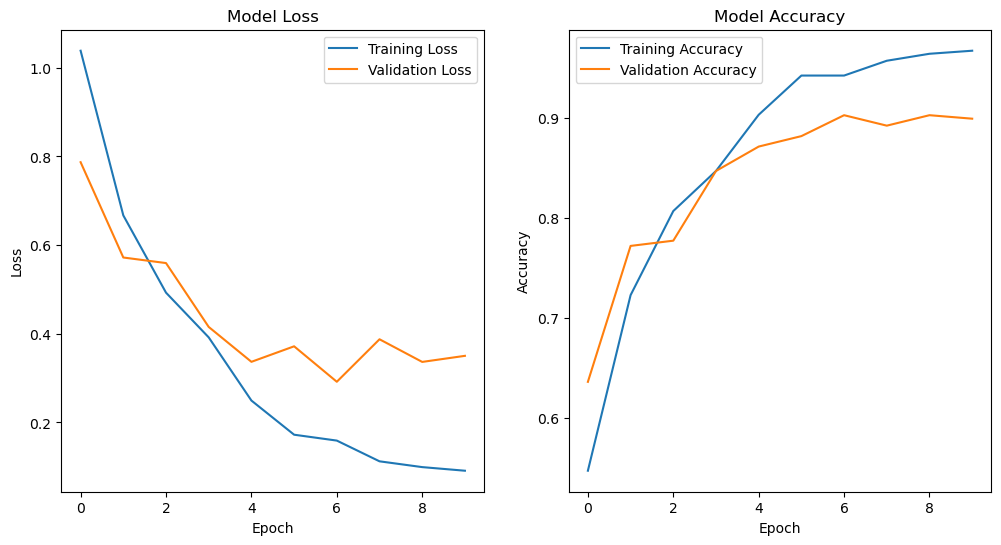

In [28]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history0.history["loss"], label="Training Loss")
plt.plot(history0.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history0.history["accuracy"], label="Training Accuracy")
plt.plot(history0.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()